In [1]:
import sys
sys.path.append("/Users/Habib/Google Drive/Uni Heidelberg/12 SS 2018/Masterarbeit")

In [2]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.feature import peak_local_max
from skimage import feature
from copy import deepcopy
import matplotlib.patches as patches
import os
from scipy.ndimage.filters import gaussian_filter
from shapes import *
from detect_bubbles import *
from evaluate import *
import pickle

In [3]:
from sklearn.ensemble import RandomForestClassifier

In [4]:
%load_ext autoreload

In [5]:
%autoreload 2

In [6]:
with open("classifiers/clf.pickle", "rb") as handle:
    clf = pickle.load(handle)

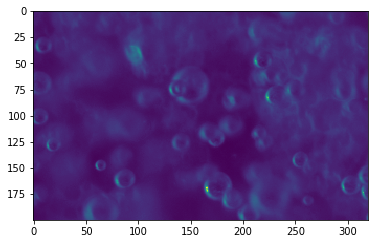

In [7]:
img = cv2.imread("data/train/train_00020.png", 0)
plt.imshow(img)

In [8]:
lm = peak_local_max(img, threshold_abs=60, min_distance=5)
local_max_candidates = [Point(l[0], l[1]) for l in lm]

In [9]:
# get features for classification
local_max_candidates_img = [extract_pad_image(input_img=img, pt=lmd, window_size=10) for lmd in local_max_candidates]
local_max_candidates_features = [get_max_features(img=im, features_window_size=3) for im in local_max_candidates_img]

In [10]:
lm_bubble = clf.predict(local_max_candidates_features)

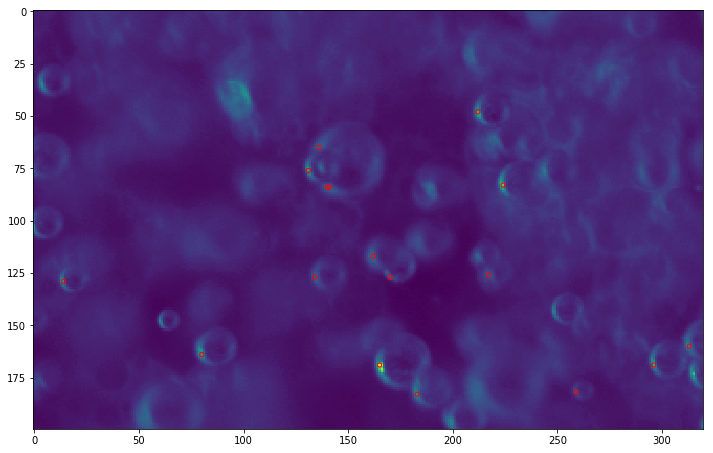

In [11]:
local_max_valid = []
fig,ax = plt.subplots(1)
fig.set_size_inches(12,12)
ax.imshow(img)
for lmd, lmb in zip(local_max_candidates, lm_bubble):
    if lmb == 1:
        local_max_valid.append(lmd)
        rect = patches.Circle((lmd.y, lmd.x),1,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)

In [12]:
curves = []
for lm in local_max_valid:
    cu = bubble_by_zeroing(input_img=img, 
                           loc_max=lm, 
                           neighbours_part="upper_right", 
                           len_curve_threshold=40, 
                           proportion_threshold=2.2)
    cu += bubble_by_zeroing(input_img=img, 
                            loc_max=lm, 
                            neighbours_part="lower_right", 
                            len_curve_threshold=40, 
                            proportion_threshold=2.2)
    curves.append(cu)

In [13]:
ref_curves = [curve_refine(curve=cu, img=img) for cu in curves]

/Users/Habib/anaconda/lib/python3.5/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


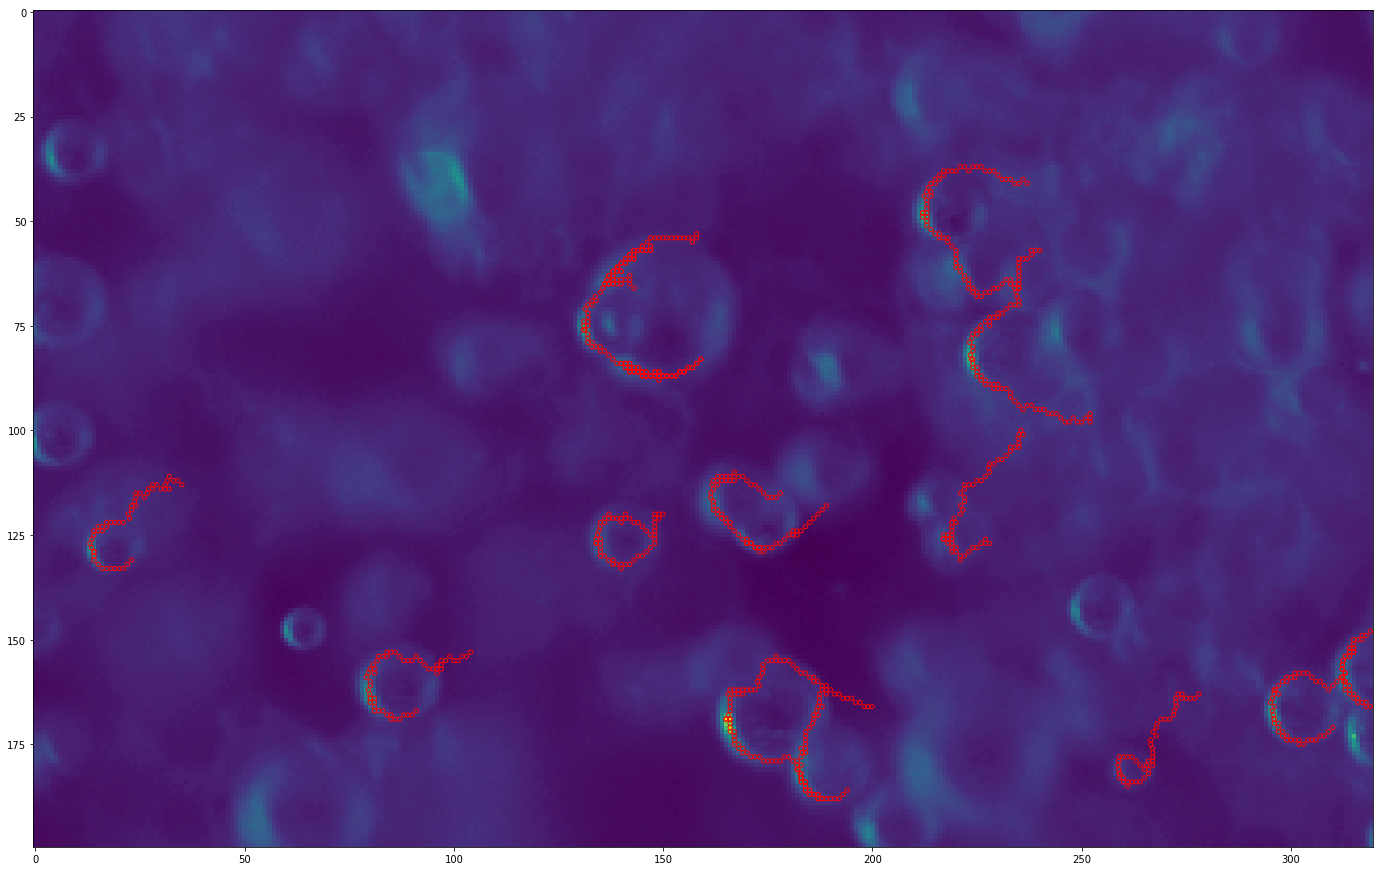

In [14]:
fig,ax = plt.subplots(1)
fig.set_size_inches(24,24)
ax.imshow(img)
for curve in (ref_curves):
    for cu in curve:
        rect = patches.Circle((cu.y, cu.x),.5,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)

In [15]:
x_data = [cu.x for cu in curve]
y_data = [cu.y for cu in curve]

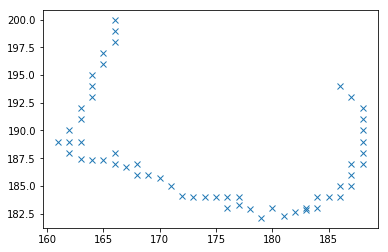

In [16]:
plt.plot(x_data, y_data, 'x')

In [18]:
def _lin_func(x):
    return  0.1*x + 0.5

In [19]:
err_data = [_lin_func(dist(cu, curve[0])) for cu in curve]

In [20]:
popt, pcov = curve_fit(half_circ, x_data, y_data, p0=[4, 100, 100], maxfev=1000)#, sigma=err_data)

In [21]:
popt

array([187.09586806,  13.19355963, -11.99521609])

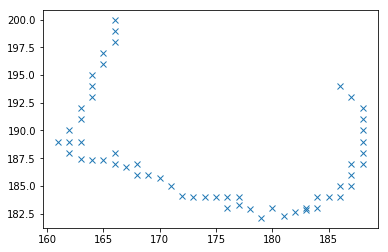

In [22]:
fig, ax = plt.subplots() 
plt.plot(x_data, y_data, 'x')
#circ = plt.Circle( (13+170,177+10), radius=popt[0], fill=False, color='r')
circ = plt.Circle((popt[1], popt[2]+x_data[0]), radius=popt[0], fill=False, color='r')
ax.add_artist(circ)

In [23]:
x_data = [cu.x for cu in curves[8]]
y_data = [cu.y for cu in curves[8]]

In [24]:
curr_curve = curves[8]

In [25]:
c = bubble_from_curve(curr_curve)

In [26]:
def _lin_func(x):
    return  0.1*x + 0.5

In [27]:
def _parab_func(x):
    return 0.01*x**2 + 0.2*x + 0.5

In [28]:
def _exp_func(x):
    return 0.01*np.exp(0.7*x)

In [29]:
err_data = [_exp_func(dist(cu, curr_curve[0])) for cu in curr_curve]

(133, 151)

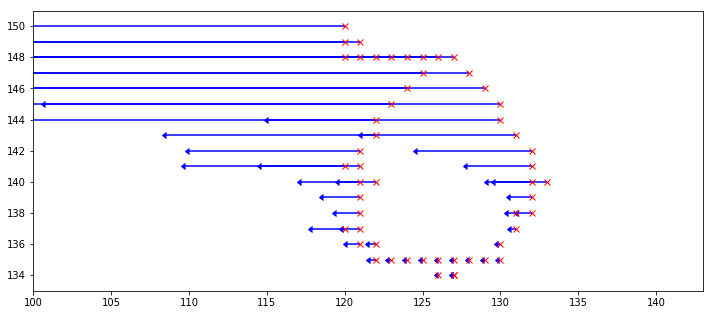

In [30]:
fig, ax = plt.subplots()
fig.set_size_inches(12,12)
ax.set_aspect('equal')
#plt.errorbar(x_data, y_data, xerr=err_data, yerr=err_data, color="r", fmt='x', xuplims=True, ecolor='b')
plt.errorbar(x_data, y_data, xerr=err_data, color="r", fmt='x', xuplims=True, ecolor='b')
plt.Line2D
plt.xlim(100, max(x_data)+10)
plt.ylim(133,151)

In [31]:
popt, pcov = curve_fit(half_circ, x_data, y_data, p0=[126, 142, 8], maxfev=1000)# sigma=err_data, absolute_sigma=True)

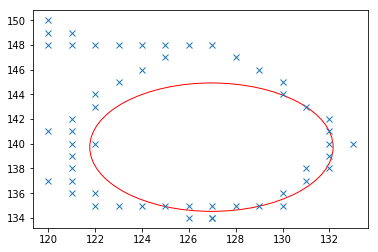

In [37]:
fig, ax = plt.subplots() 
plt.plot(x_data, y_data, 'x')
#circ = plt.Circle( (126, 142), radius=popt[0], fill=False, color='r')
circ = plt.Circle((popt[0], popt[1]+x_data[0]+1), radius=np.abs(popt[2]), fill=False, color='r')
ax.add_artist(circ)

In [ ]:
bb_pred = []
bb_pred = bubbles_from_image(img, classifier_filename="classifiers/clf.pickle", error_func=_lin_func)
bub_circ = [bubble_from_curve(curve=cu) for cu in curves]

In [ ]:
fig,ax = plt.subplots(1)
fig.set_size_inches(24,24)
ax.imshow(img)
for curve, pred in zip(curves, bb_pred):
    print("##### new curve #####")
    print("curve[0].x", curve[0].x)
    print("curve[0].y", curve[0].y)
    print("pred.xmin", pred.xmin)
    print("pred.ymin", pred.ymin)
    print("pred.xmax", pred.xmax)
    print("pred.ymax", pred.ymax)
    
    width = pred.ymax - pred.ymin
    height = pred.xmax - pred.xmin
    circ = patches.Rectangle((pred.ymin, pred.xmin), width, height,
                             linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(circ)

In [ ]:
fig1 = plt.figure(figsize=(20,20))
ax1 = fig1.add_subplot(111, aspect='equal')
plt.imshow(img)
for idx, cb in enumerate(bub_circ):
    #ax1.add_patch(patches.Circle((cb.y, cb.x), cb.radius*np.sqrt(2), fill=False, color="red"))
    #rect = circle_to_rectangle(cb)
    rect = cb
    width  = rect.ymax - rect.ymin
    height = rect.xmax - rect.xmin
    ax1.add_patch(patches.Rectangle((rect.ymin, rect.xmin), width, height, fill=False, color="r"))
    plt.text(curves[idx][0].y, curves[idx][0].x, str(idx), color="yellow")

# Evaluate

In [ ]:
xml_dir = "data/eval/xml/"
bb_true = []
for filename in os.listdir(xml_dir):
    if filename.endswith(".xml"):
        bb_true += get_ground_truth_from_xml(os.path.join(xml_dir, filename)) 
           

In [ ]:
val_dir = "data/eval/"
val_images = [cv2.imread(os.path.join(val_dir,imgfilename), 0) for imgfilename in os.listdir(val_dir) if imgfilename.endswith("png")]

In [ ]:
bb_pred = []
for vm in val_images:
    bb_pred += bubbles_from_image(vm, classifier_filename="classifiers/clf.pickle", error_func=_lin_func) 
          

In [ ]:
eval_precision_recall(true_lb=bb_true, pred_lb=bb_pred)